In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import networkx as nx # for graph operations
import timeit # for timing code

from itertools import product

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


## 1.1 Load data

In [65]:
# Adjacency matrix
df_adj = pd.read_csv('dataset/consensus_adj_mat.csv')
print(df_adj)

   Unnamed: 0  Akt  Erk  Jnk  Mek  P38  PIP2  PIP3  PKA  PKC  Plcg  Raf
0         Akt    0    0    0    0    0     0     0    0    0     0    0
1         Erk    0    0    0    0    0     0     0    0    0     0    0
2         Jnk    0    0    0    0    0     0     0    0    0     0    0
3         Mek    0    1    0    0    0     0     0    0    0     0    0
4         P38    0    0    0    0    0     0     0    0    0     0    0
5        PIP2    0    0    0    0    0     0     0    0    1     0    0
6        PIP3    1    0    0    0    0     1     0    0    0     1    0
7         PKA    1    1    1    1    1     0     0    0    0     0    1
8         PKC    0    0    1    1    1     0     0    0    0     0    1
9        Plcg    0    0    0    0    0     1     0    0    1     0    0
10        Raf    0    0    0    1    0     0     0    0    0     0    0


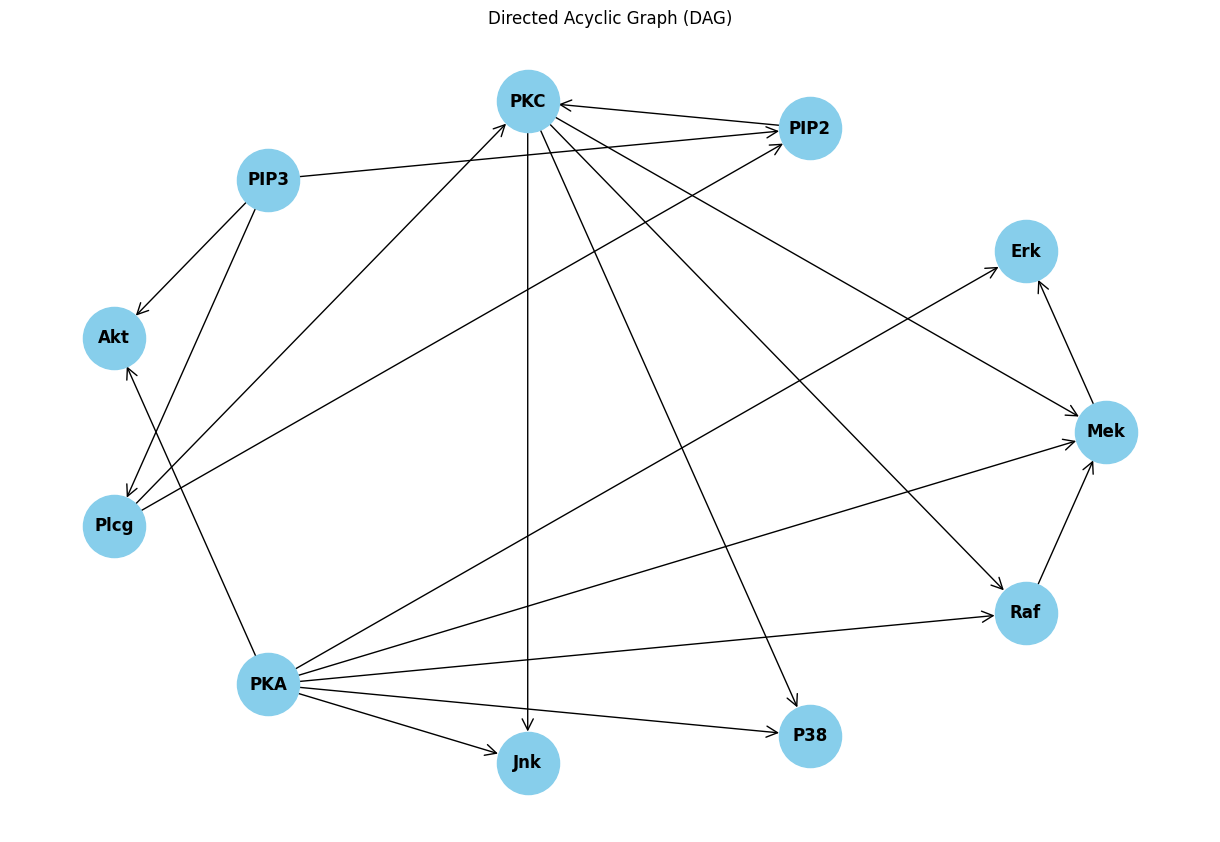

In [66]:
# Initialize a directed graph
G = nx.DiGraph()

# Rename the unnamed column for clarity
df_adj = df_adj.rename(columns={"Unnamed: 0": "Node"})

# Add edges based on the dataframe
for index, row in df_adj.iterrows():
    for col in df_adj.columns[1:]:
        if row[col] == 1:
            G.add_edge(row["Node"], col)

# Use a layout algorithm to position the nodes
pos = nx.circular_layout(G)


# Plot the graph
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=12, font_weight="bold", arrowstyle="->", arrowsize=20)
plt.title("Directed Acyclic Graph (DAG)")
plt.show()


In [67]:
print("Nodes: ", G.nodes)
print("Edges: ", G.edges)

Nodes:  ['Mek', 'Erk', 'PIP2', 'PKC', 'PIP3', 'Akt', 'Plcg', 'PKA', 'Jnk', 'P38', 'Raf']
Edges:  [('Mek', 'Erk'), ('PIP2', 'PKC'), ('PKC', 'Jnk'), ('PKC', 'Mek'), ('PKC', 'P38'), ('PKC', 'Raf'), ('PIP3', 'Akt'), ('PIP3', 'PIP2'), ('PIP3', 'Plcg'), ('Plcg', 'PIP2'), ('Plcg', 'PKC'), ('PKA', 'Akt'), ('PKA', 'Erk'), ('PKA', 'Jnk'), ('PKA', 'Mek'), ('PKA', 'P38'), ('PKA', 'Raf'), ('Raf', 'Mek')]


### sachs_bin

In [4]:
df_raw = pd.read_csv('dataset/sachs_bin.csv')
# convert to int
df_raw = df_raw.astype(int)
print(df_raw.head())
print("shape: ", df_raw.shape)

   Akt  Erk  Jnk  Mek  P38  PIP2  PIP3  PKA  PKC
0    0    0    1    0    1     0     1    0    1
1    0    0    1    0    0     0     0    0    0
2    0    0    0    1    0     0     0    0    0
3    0    0    0    1    0     0     0    0    0
4    1    0    1    0    0     0     0    0    0
shape:  (853, 9)


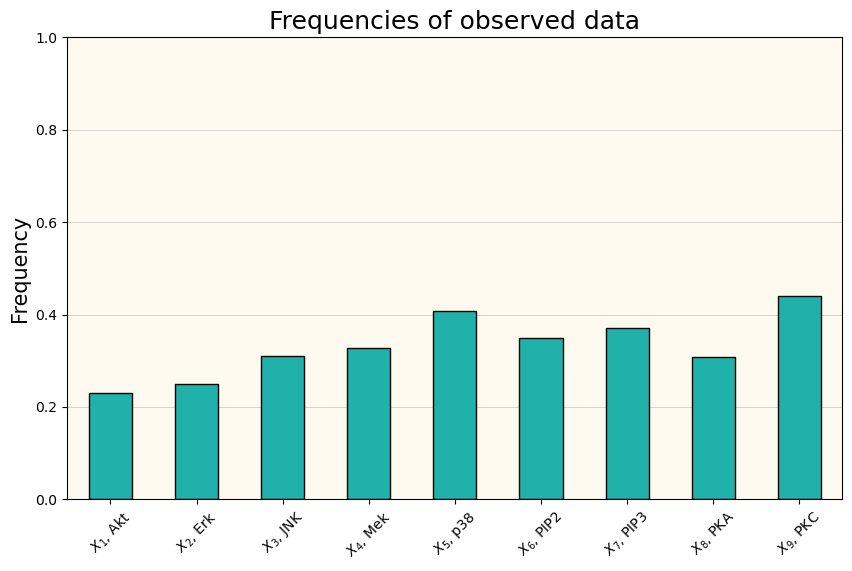

In [19]:
# Calculate the percentage of 1's for each column
percentages = df_raw.mean()
categories = ['$X_1$, Akt' , '$X_2$, Erk' ,'$X_3$, JNK' , '$X_4$, Mek' , '$X_5$, p38' , '$X_6$, PIP2' , '$X_7$, PIP3' , '$X_8$, PKA' , '$X_9$, PKC']
n = len(categories)


# Plotting
fig1, ax = plt.subplots(figsize=(10,6))
percentages.plot(kind='bar', ax=ax,color='lightseagreen',edgecolor='black')
plt.ylabel('Frequency',fontsize=15)
plt.ylim(0,1)
plt.xticks(ticks=np.arange(n),labels=categories, rotation=45)
plt.title('Frequencies of observed data',fontsize=18)
ax.set_facecolor('floralwhite')
ax.set_axisbelow(True)
plt.grid(axis='y', linestyle='-', linewidth=0.7,color='lightgray')  
plt.show()
fig1.savefig('sachs_part_i.png')

# Forward simulation

Variables

['$X_1$, Akt' , '$X_2$, Erk' ,'$X_3$, JNK' , '$X_4$, Mek' , '$X_5$, p38' , '$X_6$, PIP2' , '$X_7$, PIP3' , '$X_8$, PKA' , '$X_9$, PKC', '$X_{10}$, PLCg' , '$X_{11}$, Raf']

In [10]:
def node_to_index(nodes, parents):
    """
    Switch the from topological order to index order

    Arguments:
    nodes: list of nodes in topological order
    parents: list of parents in topological order

    Returns:
    reordered_parents: list of parents in index order
    """
    reordered_parents = [-1] * (max(nodes) + 1)
    for node, parent in zip(nodes, parents):
        reordered_parents[node] = parent
    return reordered_parents[1:max(nodes)+1]

### Convert node order

In [ ]:
alpha = 0.5
nodes = [7, 8, 1, 10, 6, 9, 3, 5, 11, 4, 2]
parents_top = [[], [], [7, 8], [7], [7,10], [10,6], [9,8], [9,8], [9,8], [11, 8, 9], [4, 8]]

parents = node_to_index(nodes, parents_top)
parents.insert(0, -1)

### Generate CPD's 

In [11]:
def synthetic_cpd(alpha, parent):
    # Create all possible combinations of parent values
    df = pd.DataFrame(list(product([0, 1], repeat=len(parent))), columns=parent)
    df['prob'] = 1 - alpha ** (1 + df.sum(axis=1)) # P(X=1|parents)
    return df

df_x1 = synthetic_cpd(alpha, parents[1])
df_x2 = synthetic_cpd(alpha, parents[2])
df_x3 = synthetic_cpd(alpha, parents[3])
df_x4 = synthetic_cpd(alpha, parents[4])
df_x5 = synthetic_cpd(alpha, parents[5])
df_x6 = synthetic_cpd(alpha, parents[6])
df_x7 = synthetic_cpd(alpha, parents[7])
df_x8 = synthetic_cpd(alpha, parents[8])
df_x9 = synthetic_cpd(alpha, parents[9])
df_x10 = synthetic_cpd(alpha, parents[10])
df_x11 = synthetic_cpd(alpha, parents[11])

print(df_x1[(df_x1[7] == 1) & (df_x1[8] == 1)]['prob'].values)

[0.875]


### Simulate

In [13]:
# condition = (df_x1[8] == 1).values

def get_parents(df : pd.DataFrame) -> list:
    return [col for col in df.columns if not str(col).startswith('prob')]


def return_probability(df : pd.DataFrame, state : list) -> int:
    '''
    It's important that the state is given in the same order  as the columns of the dataframe.    

    Arguments:
    df (pandas.DataFrame): The conditional probability table
    state (list): The state of the parents true/false
    
    Returns:
    The probability of the state 
    '''
    #Index of all columns that are not the probability
    parents = [col for col in df.columns if not str(col).startswith('prob')]

    condition = (df[parents] == state).all(axis=1)
    # Get the probability of the condition
    matching_probabilities = df.loc[condition, 'prob'] # returns the row where the condition is true
    matching_probabilities = matching_probabilities.values # single value list

    return matching_probabilities[0]

# Test the function with X1: P(X1=1|X7=0, X8=0)
print(return_probability(df_x1, [0,0]))

0.5


In [16]:
def simulate_binomial(nodes : list, print_outcomes = False):
    """
    Simulate one instance of the network corresponding to the variables X1, ..., X11.

    Arguments:
    nodes (list): The topological order of the nodes
    print_outcomes (bool): If True, print the outcomes of the simulation

    Returns:
    list: The simulated values of the nodes
    """
    
    X7, X8 = np.random.binomial(n=1, p=df_x7['prob']), np.random.binomial(n=1, p=df_x8['prob'])
    X7, X8 = X7[0], X8[0] # We want the value as an integer, not a list

    p_x1 = return_probability(df_x1, [X7, X8])
    X1 = np.random.binomial(n=1, p=p_x1)

    p_x10 = return_probability(df_x10, [X7])
    X10 = np.random.binomial(n=1, p=p_x10)

    p_x6 = return_probability(df_x6, [X7, X10])
    X6 = np.random.binomial(n=1, p=p_x6)

    p_x9 = return_probability(df_x9, [X10, X6])
    X9 = np.random.binomial(n=1, p=p_x9)

    p_x3 = return_probability(df_x3, [X9, X8])
    X3 = np.random.binomial(n=1, p=p_x3)

    p_x5 = return_probability(df_x5, [X9, X8])
    X5 = np.random.binomial(n=1, p=p_x5)

    p_x11 = return_probability(df_x11, [X9, X8])
    X11 = np.random.binomial(n=1, p=p_x11)

    p_x4 = return_probability(df_x4, [X11, X8, X9])
    X4 = np.random.binomial(n=1, p=p_x4)

    p_x2 = return_probability(df_x2, [X4, X8])
    X2 = np.random.binomial(n=1, p=p_x2)

    if print_outcomes: # if set to True, this will be executed
        print('Simulating')
        print('(X7, p) = ', ((X7, df_x7['prob'][0])), 'pa = ', get_parents(df_x7)) 
        print('(X8, p) = ', ((X8, df_x8['prob'][0])), 'pa = ', get_parents(df_x8))
        print('(X1, p) = ', ((X1, p_x1)), 'pa = ', get_parents(df_x1))
        print('(X10, p) = ', ((X10, p_x10)), 'pa = ', get_parents(df_x10))
        print('(X6, p) = ', ((X6, p_x6)), 'pa = ', get_parents(df_x6))
        print('(X9, p) = ', ((X9, p_x9)), 'pa = ', get_parents(df_x9))
        print('(X3, p) = ', ((X3, p_x3)), 'pa = ', get_parents(df_x3))
        print('(X5, p) = ', ((X5, p_x5)), 'pa = ', get_parents(df_x5))
        print('(X11, p) = ', ((X11, p_x11)), 'pa = ', get_parents(df_x11))
        print('(X4, p) = ', ((X4, p_x4)), 'pa = ', get_parents(df_x4))
        print('(X2, p) = ', ((X2, p_x2)), 'pa = ', get_parents(df_x2))

    return [X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11]

# Test the function
simulate_binomial(nodes, False)

[1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0]

In [74]:
def forward(alpha, n):
    """
    Generate n instances of the network corresponding to the variables X1, ..., X11.

    Arguments:
    alpha (float): The alpha value for the network
    n (int): The number of instances to generate

    Returns:
    pandas.DataFrame: A DataFrame with n rows and columns X1, ..., X11
    """
    lst = []
    for elm in range(0, n):
        lst.append(simulate_binomial(nodes))
    df=pd.DataFrame(lst,columns=['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11'])

    return df


### Execute forward simulation

In [ ]:
# set your preferred alpha value and number of instances:
alpha = 0.5
n = 1000

df = forward(alpha, n)

# save the data to a csv file:
df.to_csv(f'dataset/fwd_sim_{n}.csv', index=False)

## 1.3 Results from simulated data points

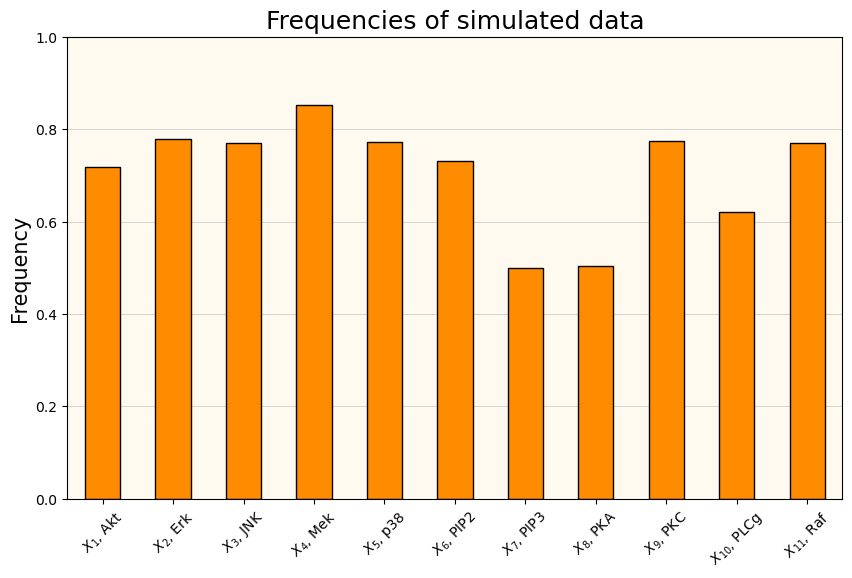

In [17]:
# Calculate the percentage of 1's for each column
fwd_sim = pd.read_csv('dataset/50K_forward_simulation.csv')

percentages=fwd_sim.mean()
categories = ['$X_1$, Akt' , '$X_2$, Erk' ,'$X_3$, JNK' , '$X_4$, Mek' , '$X_5$, p38' , '$X_6$, PIP2' , '$X_7$, PIP3' , '$X_8$, PKA' , '$X_9$, PKC' , '$X_{10}$, PLCg' , '$X_{11}$, Raf']
n = len(categories)

fig1, ax = plt.subplots(figsize=(10,6))

percentages.plot(kind='bar', ax=ax,color='darkorange',edgecolor='black')


plt.ylabel('Frequency',fontsize=15)
plt.ylim(0,1)
plt.xticks(ticks=np.arange(n),labels=categories, rotation=45)
plt.title('Frequencies of simulated data',fontsize=18)
ax.set_facecolor('floralwhite')
ax.set_axisbelow(True)
plt.grid(axis='y', linestyle='-', linewidth=0.7,color='lightgray')  
plt.show()
fig1.savefig('fwd_sim_data_part_i.png')



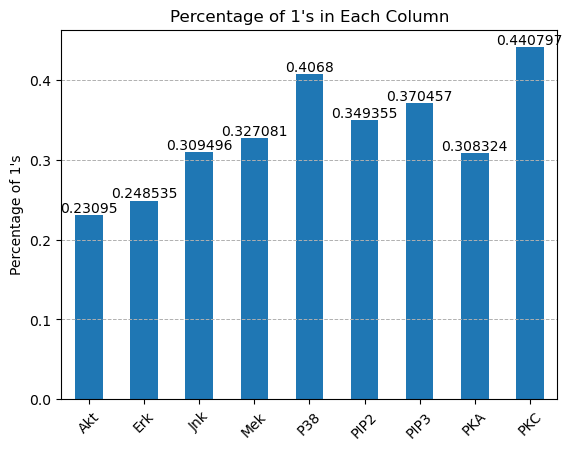

In [20]:
### should be deleted

# Plotting
fig, ax = plt.subplots()
percentages.plot(kind='bar', ax=ax)
ax.bar_label(ax.containers[0])
ax.set_ylabel('Percentage of 1\'s')
ax.set_title('Percentage of 1\'s in Each Column')
plt.xticks(rotation=45)  # Rotate labels to make them readable
plt.grid(axis='y', linestyle='--', linewidth=0.7)  # Add gridlines for better readability
plt.show()

## 1.4 Logistic regression

In [76]:
# Time the forward simulation
start = timeit.timeit()
df_sim_data = forward(0.5, 1000) # Simulate
end = timeit.timeit()
print(end - start)

6.219999340828508e-05


In [34]:
fwd_sim_ = fwd_sim.copy()
y_10 = fwd_sim_.pop('X10')
y_11 = fwd_sim_.pop('X11')


# Split the dataframe into train and test sets
X_train, X_test = train_test_split(fwd_sim_, test_size=0.2, random_state=42)
y_10_train, y_10_test = train_test_split(y_10, test_size=0.2, random_state=42)
y_11_train, y_11_test = train_test_split(y_11, test_size=0.2, random_state=42)

In [35]:
# Print the shapes of the train and test sets
print("Train set shape:", X_train.shape, "  Test set shape:", X_test.shape)
print("Train set shape:", y_10_train.shape, "    Test set shape:", y_10_test.shape)
print("Train set shape:", y_11_train.shape, "    Test set shape:", y_11_test.shape)

Train set shape: (40000, 9)   Test set shape: (10000, 9)
Train set shape: (40000,)     Test set shape: (10000,)
Train set shape: (40000,)     Test set shape: (10000,)


In [36]:
# Initialize a logistic regression model
log = LogisticRegression()

# Fit
log_reg_y_10 = log.fit(X_train, y_10_train)
log_reg_y_11 = log.fit(X_train, y_11_train)

# Predict
pred_log_reg_y_10 = log_reg_y_10.predict(X_test) 
pred_log_reg_y_11 = log_reg_y_11.predict(X_test) 

In [37]:
# print the accuracy of the model
print("Logistic Regression accuracy for X10: ", log_reg_y_10.score(X_test, y_10_test))
print("Logistic Regression accuracy for X11: ", log_reg_y_11.score(X_test, y_11_test))

Logistic Regression accuracy for X10:  0.6249
Logistic Regression accuracy for X11:  0.784
